In [1]:
import json
import pprint
from pathlib import Path
import sys
sys.path.insert(1, '../src/utils')
import ipdb

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from gensim.utils import simple_preprocess
from gensim import corpora, models
from gensim.models import Word2Vec
from gensim.models import CoherenceModel
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
from scipy.spatial.distance import cdist

from data import preprocessing

# Variables


In [2]:
num_topics = 5
use_title = True
stemming = True
lemmatization = True
lib = "spacy"

input_path = Path("../src/data/data_jmlr_vol13-21.json")

c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Data loading and preparation

## load

In [3]:
with open(input_path, encoding="utf-8") as f:
    data = json.load(f)
data_df = pd.json_normalize(data['papers'])
corpus = data_df["abstract"]
if use_title:
    corpus = data_df["title"] + " " + corpus 


c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## preprocess
TODO: save after preprocessing so that there is no need to wait for a long time

In [4]:
corpus = preprocessing(
    corpus,
    lib=lib,
    stemming=stemming,
    lemmatization=lemmatization,
    min_word_len=2,
    max_word_len=15
)

c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Dropping 0 entries of corpus, due to nan ...


2it [00:00, 16.26it/s]

Starting tokenization ...


1261it [00:52, 23.87it/s]


### tfidf

The TfidfVectorizer does additionally also tokenization and stop word removal.

In [5]:
vectorizer_sklearn = TfidfVectorizer(stop_words='english')
tfidf_corpus_sklearn_preprocessed = vectorizer_sklearn.fit_transform(corpus["abstract"])

c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Since we implemented our own preprocessing this is not necessary. Therefore we don't use tokenization and lowercase. Since we didn't implement stop word removal yet(TODO: true?) we use the stopword removal by sklearn.

In [6]:
def identity_tokenizer(text):
    return text

vectorizer = TfidfVectorizer(tokenizer=identity_tokenizer, lowercase=False)  
tfidf_corpus =  vectorizer.fit_transform(corpus["token"])  

c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## get optimal k

c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


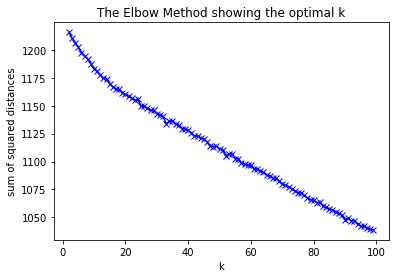

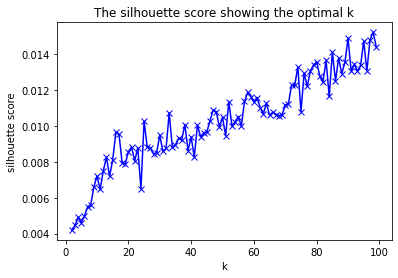

In [7]:
sum_of_suared_distances = []
silhouette_scores = []
K = range(2,100)
for k in K:
    model = KMeans(n_clusters=k, random_state=10)
    model.fit(tfidf_corpus_sklearn_preprocessed)
    sum_of_suared_distances.append(model.inertia_)
    labels = model.labels_
    silhouette_scores.append(metrics.silhouette_score(tfidf_corpus_sklearn_preprocessed, labels, metric='euclidean'))

# Plot the elbow
plt.plot(K, sum_of_suared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('sum of squared distances')
plt.title('The Elbow Method showing the optimal k')
plt.show()

# Plot silhouette scores
plt.plot(K, silhouette_scores, 'bx-')
plt.xlabel('k')
plt.ylabel('silhouette score')
plt.title('The silhouette score showing the optimal k')
plt.show()

 There is no elbow visible. There could be several reasons for this: https://stats.stackexchange.com/questions/89679/what-do-you-do-when-theres-no-elbow-point-for-kmeans-clustering

Silhouette score explained:
https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
TODO: proper visualization of silhouette score

Elbow Method explained: https://www.datanovia.com/en/lessons/determining-the-optimal-number-of-clusters-3-must-know-methods/

### silhouette score
TODO

In [8]:
centroids = model.cluster_centers_
silhouette_score = metrics.silhouette_score(tfidf_corpus_sklearn_preprocessed, labels, metric='euclidean')


c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Clustering

In [9]:
def fit_model(model, corpus):
    model.fit(corpus)

def print_clusters(model, vectorizer):
    print("Top terms per cluster:")
    order_centroids = model.cluster_centers_.argsort()[:, ::-1]
    terms = vectorizer.get_feature_names()
    for i in range(num_topics):
        print("Cluster %d:" % i),
        for ind in order_centroids[i, :10]:
            print(' %s' % terms[ind])
        print("\n")
    
model = KMeans(n_clusters=num_topics, init='k-means++', max_iter=100, n_init=1)
fit_model(model, tfidf_corpus)
print_clusters(model, vectorizer)


c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Top terms per cluster:
Cluster 0:
 matrix
 rank
 -pron-
 tensor
 low
 complet
 estim
   
 norm
 sampl


Cluster 1:
 -pron-
 optim
 convex
 algorithm
 gradient
 stochast
 problem
 function
 converg
 loss


Cluster 2:
 -pron-
 estim
 model
 regress
 kernel
 method
   
 distribut
 gaussian
 datum


Cluster 3:
 -pron-
 learn
 model
 algorithm
   
 network
 graph
 use
 datum
 set


Cluster 4:
 cluster
 -pron-
 densiti
 algorithm
 estim
 graph
 hierarch
   
 spectral
 base




Since the words which define the clusters look weird I use the sklearn preprocessing in the following. Our preprocessing should be improved. Or we decide to just use the sklearn preprocessing. But as far as I know they don't use lemmatization and stemming (TODO: true?) 

In [10]:
model = KMeans(n_clusters=num_topics, init='k-means++', max_iter=100, n_init=1)
fit_model(model, tfidf_corpus_sklearn_preprocessed)
print_clusters(model, vectorizer_sklearn)


c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Top terms per cluster:
Cluster 0:
 model
 models
 data
 inference
 graph
 causal
 graphical
 gaussian
 selection
 latent


Cluster 1:
 learning
 kernel
 bounds
 regression
 function
 algorithm
 policy
 optimal
 algorithms
 sample


Cluster 2:
 learning
 data
 machine
 python
 library
 source
 multi
 classification
 algorithms
 training


Cluster 3:
 matrix
 rank
 low
 data
 clustering
 completion
 covariance
 matrices
 sparse
 tensor


Cluster 4:
 optimization
 stochastic
 gradient
 convex
 convergence
 algorithms
 descent
 problems
 distributed
 algorithm




much better!

# Visualization
TODO: merge somehow with visualization of gensim_inspections? would be very difficult because of different inputs
TODO: in prediction einfärben

c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


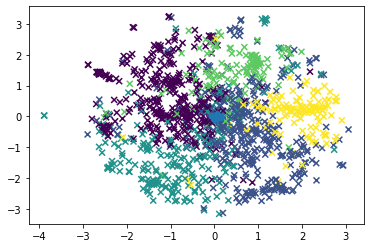

In [11]:
random_state = 1
centroids = model.cluster_centers_

tsne_init = 'pca'  # could also be 'random'
tsne_perplexity = 20.0
tsne_early_exaggeration = 4.0
tsne_learning_rate = 10
tsne = TSNE(n_components=2, random_state=random_state, init=tsne_init,
    perplexity=tsne_perplexity,
    early_exaggeration=tsne_early_exaggeration, learning_rate=tsne_learning_rate)

transformed = tsne.fit_transform(np.concatenate((tfidf_corpus_sklearn_preprocessed.todense(), centroids)))
plt.scatter(transformed[:-num_topics, 0], transformed[:-num_topics, 1], c=model.labels_, marker='x')
plt.scatter(transformed[-num_topics:, 0], transformed[-num_topics:, 1], marker='o')

plt.show()

# Prediction
TODO

In [12]:
#Y = vectorizer.transform(["chrome browser to open."])
#prediction = model.predict(Y)
#print(prediction)

#Y = vectorizer.transform(["My cat is hungry."])
#prediction = model.predict(Y)
#print(prediction)

c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
